# Simulating different noise "LFPs" and analyzing their spectral distribution

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys

sys.path.append('/Users/rdgao/Documents/code/research/neurodsp/')
import neurodsp as ndsp
sys.path.append('/Users/rdgao/Documents/code/research/spectralCV/')
from scv_funcs import lfpca, utils

### Double exponential synaptic noise LFP
Here, we simulate 1/f background activity as a convolution between Poisson noise and exponential rise and decay synaptic kernel (post-synaptic current).

In [2]:
# simulating
np.random.seed(42)
numtrials=100
T = 120
fs = 1000
tauR=0.002
tauD=0.02
syn_noise = np.zeros((numtrials, T*fs))
for tr in range(numtrials): 
    syn_noise[tr,:] = ndsp.sim_synaptic_noise(T,fs,tauR=tauR,tauD=tauD)

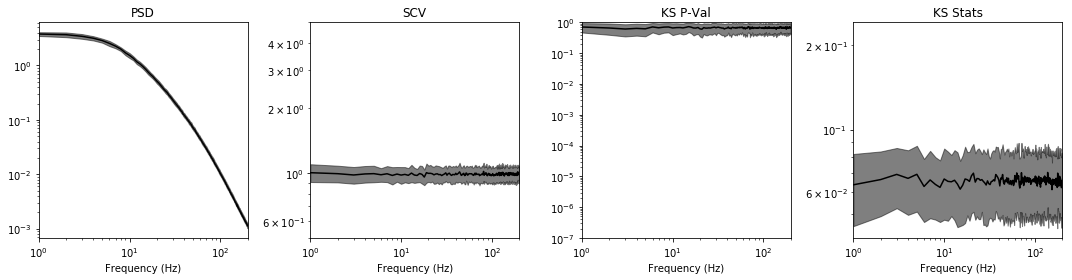

In [3]:
# analysis
params = {'nperseg':1000, 'noverlap':0, 'spg_outlierpct':0, 'max_freq':200}
sn_lfpca = lfpca.LFPCA(params)
sn_lfpca.populate_ts_data(syn_noise,fs)
sn_lfpca.compute_all_spectral()
sn_lfpca.compute_KS_expfit()
plt.figure(figsize=(15,4))
sn_lfpca.plot_spectral(plot_mean=True)

As expected, the PSD follows a plateaued 1/f function (Lorentzian), and spectral coefficient of variation (SCV) at all frequencies is equal to unity. Power distribution at all frequencies are not significantly different from exponential distribution parametrized by the mean power, under KS test.

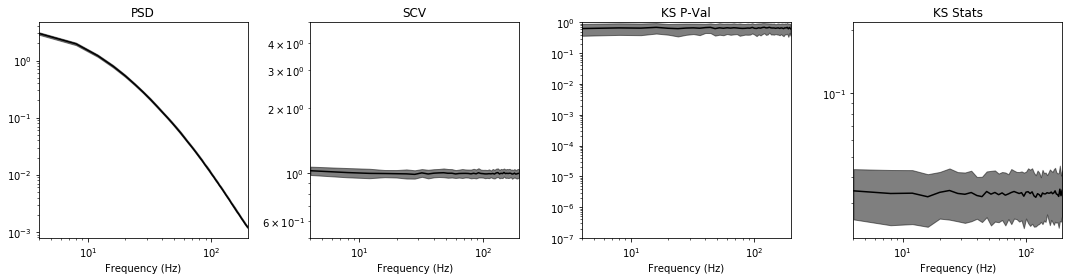

In [35]:
# analysis
params = {'nperseg':250, 'noverlap':0, 'spg_outlierpct':0, 'max_freq':200}
sn_lfpca = lfpca.LFPCA(params)
sn_lfpca.populate_ts_data(syn_noise,fs)
sn_lfpca.compute_all_spectral()
sn_lfpca.compute_KS_expfit()
plt.figure(figsize=(15,4))
sn_lfpca.plot_spectral(plot_mean=True)

Exponential distribution of power does not depend on window-length: with a smaller window length (quarter second), power in adjacent frequency bins are collapsed into every 4th bin and each bin remains exponentially distributed. This means that narrowband filtering and taking the Hilbert power in a "noise" region should maintain the noise-like properties of that band.

In [148]:
def compute_hilbert_power(data,fs,passband,N_cycles=5,ac_thr=0.05):
    # filter data
    data_filt, filt_ker = ndsp.filter(data, fs, 'bandpass', f_lo=passband[0], f_hi=passband[1], N_cycles=N_cycles, return_kernel=True)
    # get effective filter length where autocorrelation drops below the threshold for the last time
    ker_len = np.where(np.abs(utils.autocorr(filt_ker)[1])>=ac_thr)[0][-1]+1
    # get hilbert amplitude, pad filter edge artifacts with zero
    data_amp = np.ones_like(data)*np.nan
    data_amp[~np.isnan(data_filt)] = np.abs(sp.signal.hilbert(data_filt[~np.isnan(data_filt)]))**2
    # also return data-valid indices for convenience
    valid_inds = np.where(~np.isnan(data_filt))[0]
    return data_amp, valid_inds, ker_len

def bandpass_filter(x, Fs, pass_type, f_lo=None, f_hi=None, N_cycles=3, N_seconds=None,
           iir=False, butterworth_order=None,
           plot_frequency_response=False, return_kernel=False,
           verbose=True, compute_transition_band=True, remove_edge_artifacts=True):
    """
    Apply a bandpass, bandstop, highpass, or lowpass filter to a neural signal

    Parameters
    ----------
    x : array-like 1d
        voltage time series
    Fs : float
        The sampling rate
    pass_type : str
        'bandpass' : apply a bandpass filter
        'bandstop' : apply a bandstop (notch) filter
        'lowpass' : apply a lowpass filter
        'highpass' : apply a highpass filter
    f_lo : float, optional
        Low-frequency cutoff (Hz)
    f_hi : float, optional
        High-frequency cutoff (Hz)
    N_cycles : float, optional
        Length of filter in terms of number of cycles at 'f_lo' frequency
        This parameter is overwritten by 'N_seconds'
    N_seconds : float, optional
        Length of filter (seconds)
    iir : bool, optional
        if True, use an infinite-impulse response (IIR) filter
        The only IIR filter to be used is a butterworth filter
    butterworth_order : int, optional
        order of the butterworth filter
        see input 'N' in scipy.signal.butter
    plot_frequency_response : bool, optional
        if True, plot the frequency response of the filter
    return_kernel : bool, optional
        if True, return the complex filter kernel
    verbose : bool, optional
        if True, print optional information
    compute_transition_band : bool, optional
        if True, the function computes the transition bandwidth,
        defined as the frequency range between -20dB and -3dB attenuation,
        and warns the user if this band is longer than the frequency bandwidth.
    remove_edge_artifacts : bool, optional
        if True, replace the samples that are within half a kernel's length to
        the signal edge with np.nan

    Returns
    -------
    x_filt : array-like 1d
        filtered time series
    kernel : length-2 tuple of arrays
        filter kernel
        returned only if 'return_kernel' == True
    """

    # Check that frequency cutoff inputs are appropriate
    if pass_type == 'bandpass' or pass_type == 'bandstop':
        if f_lo is None or f_hi is None:
            raise ValueError('For bandpass and bandstop filters, both f_lo and f_hi must be defined.')
        if f_lo >= f_hi:
            raise ValueError('f_lo must be less than f_hi.')

    elif pass_type == 'highpass':
        if f_lo is not None:
            raise ValueError('For highpass filters, f_lo must not be used. f_hi is used to indicate the cutoff frequency.')
        if f_hi is None:
            raise ValueError('For highpass filters, f_hi must be used to represent the cutoff frequency. f_lo is not used')

    elif pass_type == 'lowpass':
        if f_hi is not None:
            raise ValueError('For lowpass filters, f_hi must not be used. f_lo is used to indicate the cutoff frequency.')
        if f_lo is None:
            raise ValueError('For lowpass filters, f_lo must be used to represent the cutoff frequency. f_hi is not used')

    else:
        raise ValueError('Input for "pass_type" not recognized. Must indicate bandpass, bandstop, lowpass, or highpass.')

    # Remove any NaN on the edges of 'x'
    first_nonan = np.where(~np.isnan(x))[0][0]
    last_nonan = np.where(~np.isnan(x))[0][-1] + 1
    x_old = np.copy(x)
    x = x[first_nonan:last_nonan]

    # Process input for IIR filters
    if iir:
        if remove_edge_artifacts:
            if verbose:
                warnings.warn('Edge artifacts are not removed when using an IIR filter.')
        if pass_type != 'bandstop':
            if verbose:
                warnings.warn('IIR filters are not recommended other than for notch filters.')
        if N_seconds is not None:
            raise TypeError('N_seconds should not be defined for an IIR filter.')
        if butterworth_order is None:
            raise TypeError('butterworth_order must be defined when using an IIR filter.')

    # Process input for FIR filters
    else:
        # Compute filter length if specified in seconds
        if N_seconds is not None:
            N = int(np.ceil(Fs * N_seconds))
        else:
            if pass_type == 'highpass':
                N = int(np.ceil(Fs * N_cycles / f_hi))
            else:
                N = int(np.ceil(Fs * N_cycles / f_lo))

        # Force filter length to be odd
        if N % 2 == 0:
            N = int(N + 1)

        # Raise an error if the filter is longer than the signal
        if N >= len(x):
            raise ValueError(
                '''The designed filter (length: {:d}) is longer than the signal (length: {:d}).
                The filter needs to be shortened by decreasing the N_cycles or N_seconds parameter.
                However, this will decrease the frequency resolution of the filter.'''.format(N, len(x)))

    # Compute nyquist frequency
    f_nyq = Fs / 2.

    # Design filter
    if iir:
        if pass_type == 'bandpass' or pass_type == 'bandstop':
            Wn = (f_lo / f_nyq, f_hi / f_nyq)
        elif pass_type == 'highpass':
            Wn = f_hi / f_nyq
        elif pass_type == 'lowpass':
            Wn = f_lo / f_nyq
        b, a = sp.signal.butter(butterworth_order, Wn, pass_type)
    else:
        if pass_type == 'bandpass':
            kernel = sp.signal.firwin(N, (f_lo, f_hi), pass_zero=False, nyq=f_nyq)
        elif pass_type == 'bandstop':
            kernel = sp.signal.firwin(N, (f_lo, f_hi), nyq=f_nyq)
        elif pass_type == 'highpass':
            kernel = sp.signal.firwin(N, f_hi, pass_zero=False, nyq=f_nyq)
        elif pass_type == 'lowpass':
            kernel = sp.signal.firwin(N, f_lo, nyq=f_nyq)

    # Apply filter
    if iir:
        x_filt = sp.signal.filtfilt(b, a, x)
    else:
        x_filt = np.convolve(kernel, x, 'same')

    # Plot frequency response, if desired
    if plot_frequency_response:
        if iir:
            _plot_frequency_response(Fs, b, a)
        else:
            _plot_frequency_response(Fs, kernel)

    # Compute transition bandwidth
    if compute_transition_band and verbose:

        # Compute the frequency response in terms of Hz and dB
        if not iir:
            b = kernel
            a = 1
        w, h = signal.freqz(b, a)
        f_db = w * Fs / (2. * np.pi)
        db = 20 * np.log10(abs(h))

        # Compute pass bandwidth and transition bandwidth
        try:
            if pass_type == 'bandpass':
                pass_bw = f_hi - f_lo
                # Identify edges of transition band (-3dB and -20dB)
                cf_20db_1 = next(f_db[i] for i in range(len(db)) if db[i] > -20)
                cf_3db_1 = next(f_db[i] for i in range(len(db)) if db[i] > -3)
                cf_20db_2 = next(f_db[i] for i in range(len(db))[::-1] if db[i] > -20)
                cf_3db_2 = next(f_db[i] for i in range(len(db))[::-1] if db[i] > -3)
                # Compute transition bandwidth
                transition_bw1 = cf_3db_1 - cf_20db_1
                transition_bw2 = cf_20db_2 - cf_3db_2
                transition_bw = max(transition_bw1, transition_bw2)

                if cf_20db_1 == f_db[0]:
                    warnings.warn('The low frequency stopband never gets attenuated by more than 20dB. Increase filter length.')
                if cf_20db_2 == f_db[-1]:
                    warnings.warn('The high frequency stopband never gets attenuated by more than 20dB. Increase filter length.')

            elif pass_type == 'bandstop':
                pass_bw = f_hi - f_lo
                # Identify edges of transition band (-3dB and -20dB)
                cf_20db_1 = next(f_db[i] for i in range(len(db)) if db[i] < -20)
                cf_3db_1 = next(f_db[i] for i in range(len(db)) if db[i] < -3)
                cf_20db_2 = next(f_db[i] for i in range(len(db))[::-1] if db[i] < -20)
                cf_3db_2 = next(f_db[i] for i in range(len(db))[::-1] if db[i] < -3)
                # Compute transition bandwidth
                transition_bw1 = cf_20db_1 - cf_3db_1
                transition_bw2 = cf_3db_2 - cf_20db_2
                transition_bw = max(transition_bw1, transition_bw2)

            elif pass_type == 'highpass':
                pass_bw = f_hi
                # Identify edges of transition band (-3dB and -20dB)
                cf_20db = next(f_db[i] for i in range(len(db)) if db[i] > -20)
                cf_3db = next(f_db[i] for i in range(len(db)) if db[i] > -3)
                # Compute transition bandwidth
                transition_bw = cf_3db - cf_20db

            elif pass_type == 'lowpass':
                pass_bw = f_lo
                # Identify edges of transition band (-3dB and -20dB)
                cf_20db = next(f_db[i] for i in range(len(db)) if db[i] < -20)
                cf_3db = next(f_db[i] for i in range(len(db)) if db[i] < -3)
                # Compute transition bandwidth
                transition_bw = cf_20db - cf_3db

            # Raise warning if transition bandwidth is too high
            if transition_bw > pass_bw:
                warnings.warn('Transition bandwidth is ' + str(np.round(transition_bw, 1)) + ' Hz. This is greater than the desired pass/stop bandwidth of ' + str(np.round(pass_bw, 1)) + ' Hz')
        except StopIteration:
            raise warnings.warn('Error computing transition bandwidth of the filter. Defined filter length may be too short.')

    # Remove edge artifacts
    if not iir and remove_edge_artifacts:
        N_rmv = int(np.ceil(N / 2))
        x_filt[:N_rmv] = np.nan
        x_filt[-N_rmv:] = np.nan

    # Add NaN back on the edges of 'x', if there were any at the beginning
    x_filt_full = np.ones(len(x_old)) * np.nan
    x_filt_full[first_nonan:last_nonan] = x_filt
    x_filt = x_filt_full

    # Return kernel if desired
    if return_kernel:
        if iir:
            return x_filt, (b, a)
        else:
            return x_filt, kernel
    else:
        return x_filt

In [147]:
noise_amp, val_inds, ker_len = compute_hilbert_power(syn_noise[0,:]-syn_noise[0,:].mean(), fs, (30,50),ac_thr=0.05)
lfpca.fit_test_exp(noise_amp[val_inds][::ker_len])

/Users/rdgao/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/rdgao/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(4.1231445312500075, 0.01810546986571754, 0.4727030261242862)

/Users/rdgao/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/rdgao/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


54


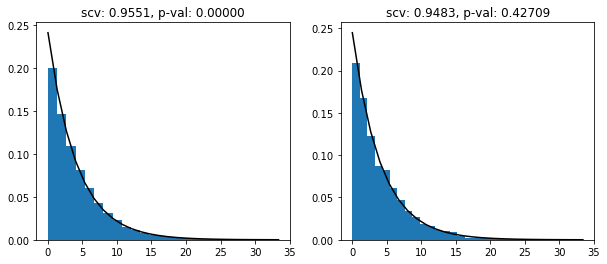

In [60]:
autocorr_thresh = 0.05
noise_filt, filt_ker = ndsp.filter(syn_noise[0,:]-syn_noise[0,:].mean(), fs, 'bandpass', f_lo=30, f_hi=50, N_cycles=5, return_kernel=True)
ker_len = np.where(abs(utils.autocorr(filt_ker)[1])>autocorr_thresh)[0][-1]
print(ker_len)
noise_amp = (np.abs(sp.signal.hilbert(noise_filt[~np.isnan(noise_filt)]))**2)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
counts,bins,_ = plt.hist(noise_amp, bins=25, normed=True);
plt.plot(bins, sp.stats.expon(scale=sp.stats.expon.fit(noise_amp,floc=0)[1]).pdf(bins), 'k-')
plt.title('scv: %.4f, p-val: %.5f'%(noise_amp.std()/noise_amp.mean(),lfpca.fit_test_exp(noise_amp)[2]))

noise_amp_decorr = noise_amp[::ker_len]
plt.subplot(1,2,2)
plt.hist(noise_amp_decorr, bins=25, normed=True);
plt.plot(bins, sp.stats.expon(scale=sp.stats.expon.fit(noise_amp_decorr,floc=0)[1]).pdf(bins), 'k-')
plt.title('p-val: %.5f'%lfpca.fit_test_exp(noise_amp_decorr)[2]);
plt.title('scv: %.4f, p-val: %.5f'%(noise_amp_decorr.std()/noise_amp_decorr.mean(),lfpca.fit_test_exp(noise_amp_decorr)[2]));

### Simulating stationary and bursty oscillation in noise
Now add a stationary oscillation (theta) and a bursty oscillation (beta) to the underlying 1/f background. We should expect the theta band to have low SCV, while beta band to have high SCV.

In [12]:
# simulating
np.random.seed(42)
numtrials=50
T = 120
fs = 1000
tauR=0.002
tauD=0.02
theta_freq=4.5
theta_amp=10
beta_freq=23.3
beta_amp=4
syn_osc = np.zeros((numtrials, T*fs))
for tr in range(numtrials): 
    noise = ndsp.sim_synaptic_noise(T,fs,tauR=tauR,tauD=tauD)
    # stationary theta: high entering probability and low leaving probability
    theta = ndsp.sim_bursty_oscillator(theta_freq,T,fs, rdsym=0.5, prob_enter_burst=1, prob_leave_burst=0.1)
    # bursty beta: low entering probability and low leaving probability
    beta = ndsp.sim_bursty_oscillator(beta_freq,T,fs, rdsym=0.5, prob_enter_burst=0.1, prob_leave_burst=0.1)
    syn_osc[tr,:] = noise+theta_amp*theta+beta_amp*beta

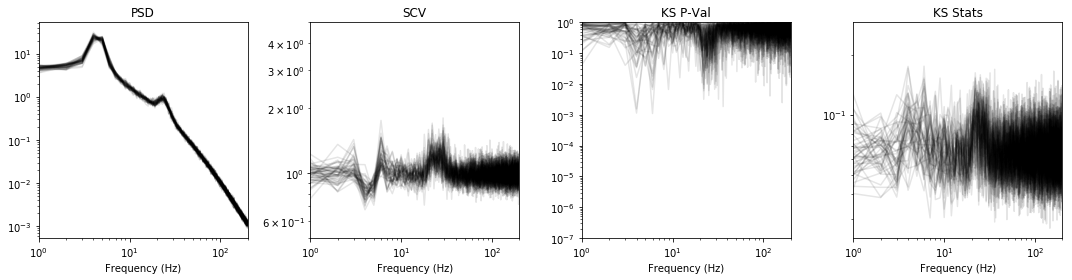

In [13]:
# analysis
params = {'nperseg':1000, 'noverlap':0, 'spg_outlierpct':0, 'max_freq':200}
osc_lfpca = lfpca.LFPCA(params)
osc_lfpca.populate_ts_data(syn_osc,fs)
osc_lfpca.compute_all_spectral()
osc_lfpca.compute_KS_expfit()
plt.figure(figsize=(15,4))
osc_lfpca.plot_spectral(plot_mean=False)

As expected, we see two peaks in the PSD, one at theta and one at beta frequency. However, the theta frequencies have SCV<1 due to a steady concentration of power, while the beta frequencies have higher variability. All other frequencies remain noise-like. Both frequency bands test significantly different from the exponential null more often.

### Simulating "asynchronous" oscillator
Now we simulate an oscillation that rises above the background 1/f, but retains noise-like statistics, i.e. narrow-band filtered noise.

In [118]:
# simulating
np.random.seed(42)
numtrials=50
T = 120
fs = 1000
tauR=0.002
tauD=0.02
beta_white_amp=30.
beta_color_amp=2
syn_white_osc = np.zeros((numtrials, T*fs))
syn_color_osc = np.zeros((numtrials, T*fs))
for tr in range(numtrials): 
    noise = ndsp.sim_synaptic_noise(T,fs,tauR=tauR,tauD=tauD)
    # narrowband filtered WHITE noise
    async_beta_white = ndsp.filter(np.random.randn((T+1)*fs),fs,'bandpass',f_lo=23,f_hi=27,N_cycles=9)
    syn_white_osc[tr,:] = noise+beta_white_amp*async_beta_white[~np.isnan(async_beta_white)][:len(noise)]

    # narrowband filtered SYNAPTIC noise
    async_beta_color = ndsp.filter(ndsp.sim_synaptic_noise(T+1.,fs,tauR=tauR,tauD=tauD),fs,'bandpass',f_lo=23,f_hi=27,N_cycles=9)
    syn_color_osc[tr,:] = noise+beta_color_amp*async_beta_color[~np.isnan(async_beta_color)][:len(noise)]

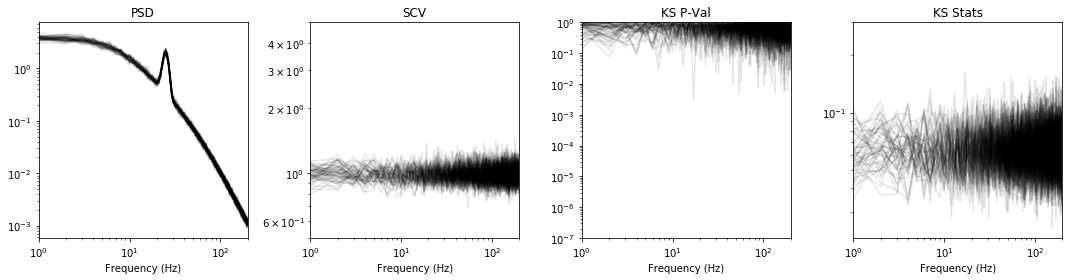

In [119]:
# analysis
params = {'nperseg':1000, 'noverlap':0, 'spg_outlierpct':0, 'max_freq':200}
osc_lfpca = lfpca.LFPCA(params)
osc_lfpca.populate_ts_data(syn_white_osc,fs)
osc_lfpca.compute_all_spectral()
osc_lfpca.compute_KS_expfit()
plt.figure(figsize=(15,4))
osc_lfpca.plot_spectral(plot_mean=False)

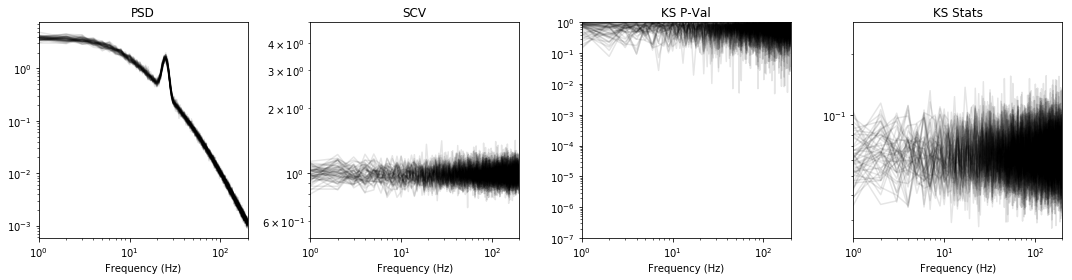

In [120]:
# analysis
params = {'nperseg':1000, 'noverlap':0, 'spg_outlierpct':0, 'max_freq':200}
osc_lfpca = lfpca.LFPCA(params)
osc_lfpca.populate_ts_data(syn_color_osc,fs)
osc_lfpca.compute_all_spectral()
osc_lfpca.compute_KS_expfit()
plt.figure(figsize=(15,4))
osc_lfpca.plot_spectral(plot_mean=False)

- Since the amplitude of the noise-filtered oscillation retains its exponential distribution, it cannot be detected based on SCV or KS test.

### Simulating oscillations and ERP-like events (or, SCP) in noise

In [9]:
def noise_analysis(x, num_trials, fs, analysis_params=None):
    if analysis_params is None:
        nperseg = int(fs)
        noverlap = 0
    else:
        nperseg = analysis_params['nperseg']
        noverlap = analysis_params['noverlap']            
    
    psd = []
    scv = []
    spg = []
    exp_scale = []
    for tr in range(num_trials):
        print(tr,end=', ')
        _, psd_ = ndsp.spectral.psd(x[:,tr], Fs=fs, nperseg=nperseg, noverlap=noverlap)
        f_axis, scv_ = ndsp.spectral.scv(x[:,tr], Fs=fs, nperseg=nperseg, noverlap=noverlap)
        _, _, spg_ = sp.signal.spectrogram(x[:,tr], fs=fs, nperseg=nperseg, noverlap=noverlap)

        # fit exponential distribution
        scale_ = np.zeros(len(f_axis))
        for f in range(len(f_axis)):
            _, scale_[f] = sp.stats.expon.fit(spg_[f,:], floc=0)
        
        # collect
        psd.append(psd_)
        scv.append(scv_)
        exp_scale.append(scale_)
    
    print('Done')
    return f_axis, np.array(psd), np.array(scv), np.array(exp_scale)

def plot_spectral(f_axis, data_plot, p_inds=np.arange(1,300)):
    titles = ['PSD', 'SCV', 'Exponential Scale Param']
    plt.figure(figsize=(12,4))
    for p in range(3):
        plt.subplot(1,3,p+1)    
        d_mean = np.mean(data_plot[p],axis=0)
        d_std = np.std(data_plot[p],axis=0)
        plt.fill_between(f_axis[p_inds],d_mean[p_inds]-d_std[p_inds],d_mean[p_inds]+d_std[p_inds], alpha=0.5)
        plt.loglog(f_axis[p_inds],d_mean[p_inds])
        if p==1:
            plt.plot([f_axis[p_inds[0]], f_axis[p_inds[-1]]], [1,1], 'k-')
        plt.xlim([f_axis[p_inds[0]], f_axis[p_inds[-1]]])
        plt.xlabel('Frequency (Hz)')
        plt.title(titles[p])
    
    p_inds = np.arange(1,300)
    data_plot = [psd, scv, exp_scale]
    plt.tight_layout()

In [3]:
dt = 0.001
fs = 1/dt
num_trials = 100
t_end = 120
t = np.arange(0,t_end,dt)
params = {
    'mu': 25,
    'sigma': 5, # variance equals mean (Poisson process)
    'theta': 10, # OU memory
    'tau': 0.05 # 
}


### white noise simulation

In [11]:
x = scv_funcs.sim_noise(t, num_trials=num_trials, color='white', params=params)
f_axis, psd, scv, exp_scale = noise_analysis(x, num_trials, fs)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, Done


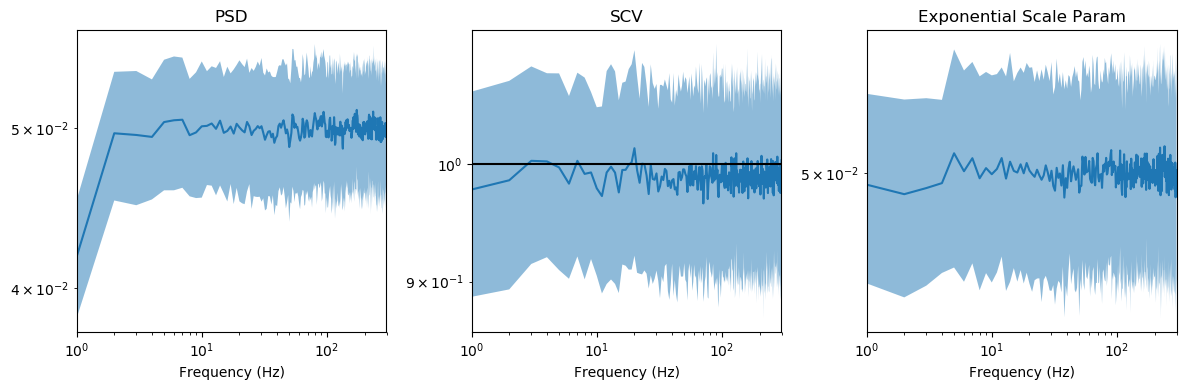

In [13]:
p_inds = np.arange(1,300)
data_plot_white = [psd, scv, exp_scale]
plot_spectral(f_axis, data_plot_white, p_inds)

### colored noise simulation

In [7]:
params = {
    'mu': 25,
    'sigma': 5, # variance equals mean (Poisson process)
    'theta': 10, # OU memory
    'tau': 0.05 # 
}
x = scv_funcs.sim_noise(t, num_trials=num_trials, color='colored', params=params)
f_axis, psd, scv, exp_scale = noise_analysis(x, num_trials, fs)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, Done


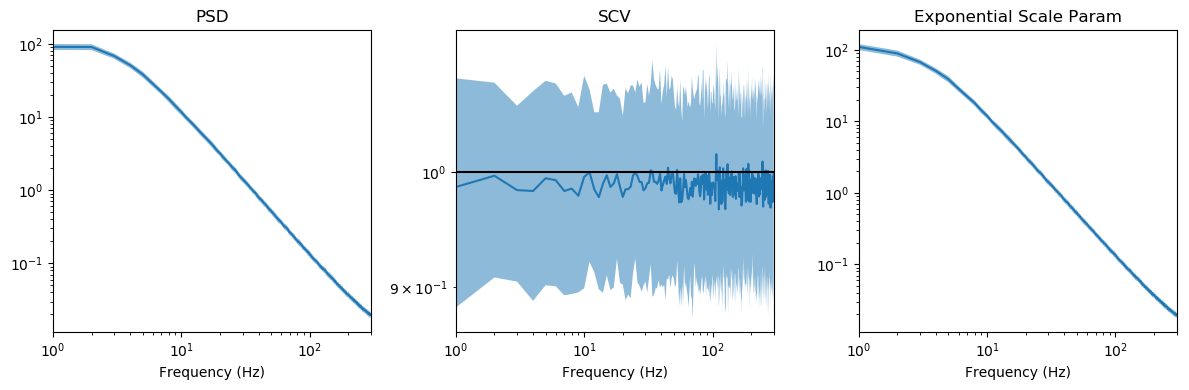

In [10]:
p_inds = np.arange(1,300)
data_plot_colored = [psd, scv, exp_scale]
plot_spectral(f_axis, data_plot_colored, p_inds)

### OU process simulation

In [14]:
params = {
    'mu': 25,
    'sigma': 5, # variance equals mean (Poisson process)
    'theta': 1, # OU memory
    'tau': 0.05 # 
}
x = scv_funcs.sim_noise(t, num_trials=num_trials, color='OU', params=params)
f_axis, psd, scv, exp_scale = noise_analysis(x, num_trials, fs)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, Done


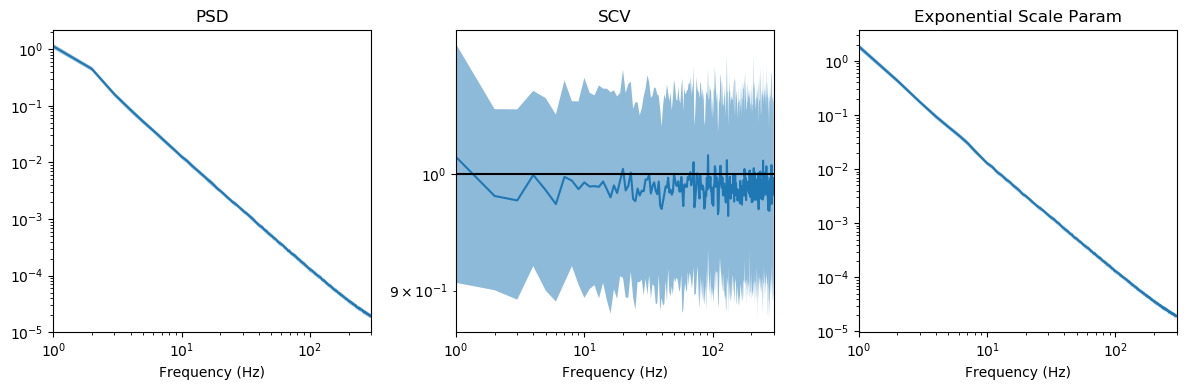

In [15]:
p_inds = np.arange(1,300)
data_plot_OU = [psd, scv, exp_scale]
plot_spectral(f_axis, data_plot_OU, p_inds)

In [ ]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sklearn
import sys

sys.path.append('/Users/rgao/Documents/Code/research/neurodsp/')
from neurodsp import spectral
import neurodsp as ndsp


### white and colored noise simulation
Here, we simulate white and colored noise (plus oscillation) and compute the spectral CV to see if they are indeed equal to 1.

In [ ]:
fs = 1000.
t = np.arange(0.,600.,1./fs)
ker = np.exp(-50*np.arange(0,500)/1000.)

# oscillation
oFreq = 20.22
oAmp = 20
# steady sinusoidal oscillation
osc = np.sin(2*np.pi*oFreq*np.arange(0,len(t))/fs)*1.

# initialize array
numtrs = 10
SCVnoise = np.zeros((numtrs,501,3))
for tr in range(0,numtrs):
    # run through trials
    print(tr, end=' ')
    # white noise
    x = np.random.normal(size=(len(t)))
    f, SCV = spectral.scv(x, fs, noverlap=0)
    SCVnoise[tr,:,0] = SCV
    
    # colored noise
    y = np.convolve(x,ker,mode='same')
    f, SCV = spectral.scv(y, fs, noverlap=0)
    SCVnoise[tr,:,1] = SCV    
    
    #colored noise plus oscillation
    # oscillation is bandpassed white noise, instead of just sinusoid
    #osc = ndsp.filter(np.random.normal(size=(len(t))), fs, 'bandpass', f_lo=20, f_hi=25, N_cycles=5, remove_edge_artifacts=False)*oAmp
    f, SCV = spectral.scv(y+osc, fs, noverlap=0)
    SCVnoise[tr,:,2] = SCV    


In [ ]:
mSCV = np.squeeze(np.mean(SCVnoise,axis=0))
sSCV = np.squeeze(np.std(SCVnoise,axis=0))
plt.figure(figsize=(15,5))
labels = ('white noise', 'colored noise', 'colored noise + osc')
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.fill_between(f,mSCV[:,i]-sSCV[:,i], mSCV[:,i]+sSCV[:,i], alpha=0.2)
    plt.plot(mSCV[:,i])
    plt.xlim((1,200))
    plt.title(labels[i],fontsize = 28)

plt.rcParams.update({'font.size': 15})
plt.subplot(1,3,1)
plt.xlabel('Frequency (Hz)',fontsize = 22)
#plt.subplot(1,3,1)
plt.ylabel('SCV',fontsize = 22)
plt.tight_layout()

In [ ]:
faxis, taxis, spg = sp.signal.spectrogram(y, fs, nperseg=int(fs), noverlap=int(fs/4.))
plt.figure(figsize=(2,2))
plt.hist(spg[:,50], bins=np.linspace(0,0.02,100));
#plt.hist(spg[:,50]**0.5, bins=np.linspace(0,0.2,100));
plt.xlabel('Power')
#plt.xticks([0., 0.01, 0.02])
plt.ylabel('Count')
plt.title('50Hz Power Distribution')

### colored noise and oscillation demonstration
Just to visualize the scale of the oscillation compared to the noise process.

In [ ]:
oFreq = 20.22
oAmp = 1.
fs = 1000.
t = np.arange(0.,600.,1./fs)
x = np.random.normal(size=(len(t)))
ker = np.exp(-50*np.arange(0,500)/1000.)
osc = np.sin(2*np.pi*oFreq*np.arange(0,len(t))/fs)*oAmp
#osc = ndsp.filter(np.random.normal(size=(len(t))), fs, 'bandpass', f_lo=20, f_hi=23, N_cycles=10, remove_edge_artifacts=False)*20.
y = np.convolve(x,ker,mode='same')+osc
f, PSD = spectral.psd(y, fs)
f, SCV = spectral.scv(y, fs, noverlap=0)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(t,y)
plt.plot(t,osc)
plt.xlim((1,2))
plt.xlabel('Time (s)',fontsize = 22)
plt.ylabel('Voltage (s)',fontsize = 22)
plt.title('Time series',fontsize = 28)


plt.subplot(1,3,2)
plt.loglog(f,PSD)
plt.xlim((1,200))
plt.xlabel('Frequency (Hz)',fontsize = 22)
plt.ylabel('Power',fontsize = 22)
plt.title('Power Spectrum',fontsize = 28)


plt.subplot(1,3,3)
plt.plot(f,SCV)
plt.plot(f,[1.]*len(f))
plt.xlim((1,200))
plt.xlabel('Frequency (Hz)',fontsize = 22)
plt.ylabel('SCV',fontsize = 22)
plt.title('SCV',fontsize = 28)
plt.tight_layout()

### time resolved SCV from bandpass filtered signal
Just use amp_by_time in neurodsp 

In [ ]:
sys.path.append('/Users/rgao/Documents/Code/research/CFBW_analysis/')
import CFBW

yfilt = ndsp.timefrequency.amp_by_time(y,fs,(18,22),filter_kwargs={'N_cycles': 5})**2.
plt.figure(figsize=(12,3))

plt.subplot(1,4,1)
plt.plot(t,yfilt)
plt.xlim([0,10])
plt.title('Bandpassed Power')

plt.subplot(1,4,2)
plt.hist(yfilt, bins=50);
plt.title('Power Distribution')

scv_run = []
for win in CFBW.utils.slidingWindow(yfilt,winLen=int(fs*2.),stepLen=int(fs/2)):
    scv_run.append(np.std(win)/np.mean(win))

plt.subplot(1,4,3)
plt.plot(np.array(scv_run))
plt.title('Sliding Window SCV')

plt.subplot(1,4,4)
plt.hist(np.array(scv_run), bins=50)
plt.title('SCV Distribution')

plt.tight_layout()
print('SCV:', np.std(yfilt)/np.mean(yfilt))

### Resampled calculation of SCV for colored noise

In [ ]:
f, T, SCVrs = spectral.scv_rs(y, fs, method='bootstrap')
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.loglog(f, SCVrs, 'k', alpha=0.2);
plt.loglog(f, np.mean(SCVrs,axis=1));
plt.xlim((1,100))
plt.xlabel('Frequency (Hz)')
plt.ylabel('SCV')

plt.subplot(1,2,2)
plt.imshow(np.log10(SCVrs), aspect='auto', extent=(0,1,f[-1],f[0]))
plt.colorbar(label='SCV')
plt.ylim((200,0))
plt.xticks([])
plt.xlabel('Slices')
plt.ylabel('Frequency (Hz)')

### Ornstein-Uhlenbeck process
OU process has a longer memory than the smoothed white noise, acheiving "true" colored noise.

Simulating a discrete-time OU process:
https://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab


In [ ]:
th = 1. # memory scale (higher = faster fluc)
mu = 0. # mean
sig = 5. # std
fs = 1000.
dt = 1./fs
t = np.arange(0.,600.,1./fs)
rand = np.random.normal(size=len(t))
x0 = 0.
ex = np.exp(-th*t);
rand[0]=0.
x = x0*ex+mu*(1.-ex)+sig*ex*np.cumsum(np.exp(th*t)*np.sqrt(dt)*rand) + osc

In [ ]:
f, PSD = spectral.psd(x, fs)
f, SCV = spectral.scv(x, fs, noverlap=0)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(t,x, alpha=1.)
plt.xlim((0,10.))
plt.xlabel('Time (s)')
plt.ylabel('Voltage (s)')

plt.subplot(1,3,2)
plt.loglog(f,PSD)
plt.xlim((0,200))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

plt.subplot(1,3,3)
plt.plot(f,SCV)
plt.plot(f,[1.]*len(f))
plt.xlim((1,200))
plt.xlabel('Frequency (Hz)')
plt.ylabel('SCV')